In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/colab_notebooks/11785DL/project/

/content/drive/MyDrive/colab_notebooks/11785DL/project


In [4]:
%ls

knnw-720p.tar                knnw_en_sub.csv  model_result/
knnw_en.log_spectrogram.npy  knnw_en_sub.srt


In [5]:
import pandas
import numpy
import torch

In [6]:
print("Subtitle Lookup Preview:")
pandas.read_table("knnw_en_sub.csv", sep = ";", header=0).head()

Subtitle Lookup Preview:


,Number,Start time in milliseconds,End time in milliseconds,Text
0,1,1650,10800,TOHO CORPORATION
1,2,53940,58090,"Some mornings, I wake up crying without knowin..."
2,3,58700,61440,That's when everything happens now and again.
3,4,62060,66540,"Whatever that dream was I had, I can never rem..."
4,5,66540,69550,- But... - But...


In [7]:
text = pandas.read_table("knnw_en_sub.csv", sep = ";", header=0)['Text']
text_numpy = np.array(text)
text_numpy[:5]

array(['TOHO CORPORATION',
       'Some mornings, I wake up crying without knowing why.',
       "That's when everything happens now and again.",
       'Whatever that dream was I had, I can never remember it.',
       '- But... - But...'], dtype=object)

In [ ]:
print("Audio Shape:")
numpy.load("knnw_en.log_spectrogram.npy").shape

Audio Shape:


(129, 1370582)

In [8]:
class KnnwAudioDataset(torch.utils.data.Dataset):
    
    def __init__(self, 
                 audio_path="knnw_en.log_spectrogram.npy",
                 subtitle_lookup_path="knnw_en_sub.csv",
                 total_frames=1370582, 
                 total_duration=6396010):
        
        self.duration_per_frame = total_duration / total_frames
        
        self.audio = numpy.load(audio_path)
        
        self.subtitle_lookup = pandas.read_table(subtitle_lookup_path, 
                                                 sep = ";", header=0)
        
        self.length = len(self.subtitle_lookup)
        
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, i):
        
        start_time = self.subtitle_lookup.iloc[i, 1]
        stop_time = self.subtitle_lookup.iloc[i, 2]
        
        audio_range = self.get_range(start_time, stop_time)
        
        audio_item = self.audio[:,audio_range]
        
        subtitle_item = self.subtitle_lookup.iloc[i, 3]
        subtitle_item = self.get_tokenization(subtitle_item) # 'TOHO CORPORATION'
        index_transcript = self.transform_letter_to_index(subtitle_item) # type <list>
        #print(audio_item.T.shape)
        #print(index_transcript)
        
        return torch.tensor(audio_item.T), torch.tensor(index_transcript)
        
    def get_index(self, time, start_flag):
        
        if start_flag == True:
            return numpy.floor(time/self.duration_per_frame)
        
        else:
            return numpy.ceil(time/self.duration_per_frame)
        
    def get_range(self, start_time, end_time):
        
        start_index = self.get_index(start_time, start_flag=True)
        stop_index  = self.get_index(end_time, start_flag=False)
        
        return range(int(start_index), int(stop_index))
    
    def get_tokenization(self, subtitle_item):
        
        return subtitle_item

    def transform_letter_to_index(self, subtitle_sentence):

        LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
         'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', '!', ',', '?', ' ', '<eos>']
        letter2index = {letter:index for index, letter in enumerate(LETTER_LIST)}

        index_transcript = []
        index_transcript.append(letter2index[LETTER_LIST[0]])
        for letter in subtitle_sentence: 
            if letter.lower() in LETTER_LIST:
                index_transcript.append(letter2index[letter.lower()])
        index_transcript.append(letter2index[LETTER_LIST[-1]])

        return index_transcript

def collate_train_val(data):
    """
    Return:
        pad_x: the padded x (training/validation speech data) 
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    Xs, ys, x_lengths, y_lengths = [], [], [], []

    for x,y in data:
        Xs.append(x)
        ys.append(y)
        x_lengths.append(x.shape[0])
        y_lengths.append(len(y))
    return (rnn_utils.pad_sequence(Xs, batch_first=False), x_lengths), (rnn_utils.pad_sequence(ys, batch_first=True), y_lengths)

In [9]:
dataset = KnnwAudioDataset()

In [10]:
next(iter(dataset))

(tensor([[-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103],
         [-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103],
         [-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103],
         ...,
         [-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103],
         [-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103],
         [-9.2103, -9.2103, -9.2103,  ..., -9.2103, -9.2103, -9.2103]]),
 tensor([ 0, 20, 15,  8, 15, 35,  3, 15, 18, 16, 15, 18,  1, 20,  9, 15, 14, 36]))

**Further Reading: How do I split a custom dataset into training and test datasets?**

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

dataset = KnnwAudioDataset()
batch_size = 1
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=collate_train_val)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, collate_fn=collate_train_val)

In [ ]:
### Still need to pad
for batch_index, (audio_item, subtitle_item) in enumerate(train_loader):
    if batch_index < 3:
        print('batch_index', batch_index)
        print(audio_item.shape)
        print(subtitle_item)
        
        #, audio_item, audio_item.shape, '\n', subtitle_item, subtitle_item.shape)

### Data Loader

In [ ]:
!pip3 install python-Levenshtein

In [14]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data
import Levenshtein

cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")
np.random.seed(5111785)
torch.manual_seed(5111785)

LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
         'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', '!', ',', '?', ' ', '<eos>']

True 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


In [15]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    letter2index = {letter:index for index, letter in enumerate(letter_list)}
    index2letter = {index:letter for index, letter in enumerate(letter_list)}
    return letter2index, index2letter
    
def transform_letter_to_index(raw_transcripts):
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''  
    index_transcript = []
    for sentence in raw_transcripts:
      try:
        sentence = " ".join([word.decode("utf-8") for word in sentence])
      except:
        sentence = " ".join([word for word in sentence])
      index_transcript.append([letter2index[LETTER_LIST[0]]]+[letter2index[letter] for letter in sentence]+[letter2index[LETTER_LIST[-1]]])
    return index_transcript

def transform_index_to_letter(index_transcript):
    letter_transcript = []
    for idx in index_transcript:
      letter_transcript.append(
          ''.join(
              [LETTER_LIST[int(idx[i])] for i in range(len(idx))]
              )
          )
    
    return letter_transcript
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [16]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)

    def forward(self, x, lens):
      x, hidden_state = self.blstm(x)
      #print("input >>>>>",x.shape)
      x, output_lens = rnn_utils.pad_packed_sequence(x, batch_first=True)
      #print("shape:", x.shape)
      if x.shape[1] % 2 != 0:
        x = x[:,:-1,:]
        #print("shape:", x.shape)
      x = x.reshape(x.shape[0], x.shape[1]//2, x.shape[2]*2)
      #print("after reshape:", x.shape)
      out = rnn_utils.pack_padded_sequence(x, output_lens//2, enforce_sorted=False, batch_first=True) # repack for next layer
      # print("out shape:", out.shape)
      return out, np.array(output_lens)//2

In [17]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.
    Key and value are linear projections of the output from pBLSTM network for the laster.
    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM at the very bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, num_layers=1, bidirectional=True, batch_first=True)


        # TODO: Define the blocks of pBLSTMs
        # ...
        self.pBiLSTM1 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        self.pBiLSTM2 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        self.pBiLSTM3 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        # The linear transformation for producing Key and Value for attention
        # Since you are using bidirectional LSTM, be careful about the size of hidden dimension
        self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
        self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    def forward(self, x, x_len):
      # print(x_len)
      # print(x.shape)
      # Pass through the first LSTM at the very bottom
      packed_sequence = rnn_utils.pack_padded_sequence(x, x_len, enforce_sorted=False, batch_first=False) 
      packed_out, _ = self.lstm(packed_sequence)
      # unpacked, _ = rnn_utils.pad_packed_sequence(packed_out)
      

      # TODO: Pass through the pBLSTM blocks
      # ...
      layer_out, new_len = self.pBiLSTM1(packed_out, x_len)
      layer_out, new_len = self.pBiLSTM2(layer_out, new_len)
      layer_out, new_len = self.pBiLSTM3(layer_out, new_len)
      # Unpack the sequence and get the Key and Value for attention
      pblstm_out, unpacked_x_len = rnn_utils.pad_packed_sequence(layer_out, batch_first=True)
      
      keys = self.key_network(pblstm_out)
      values = self.value_network(pblstm_out)
      return keys, values, unpacked_x_len

In [18]:
def plot_attention(attention):
    plt.clf()
    sns.heatmap(attention, cmap='hot')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, mask):
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_szie, max_len, hidden_size), (batch_size, hidden_size, 1) 
        # Output shape of bmm: (batch_size, max_len, 1)
        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        
        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask_lengths = torch.arange(key.size(1)).unsqueeze(0) >= mask.unsqueeze(1)
        
        # Set attention logits at padding positions to negative infinity.
        energy.masked_fill_(mask_lengths.to(device), -1e9)
        
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(energy, dim=1)
        
        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size) 
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)
        
        # attention vectors are returned for visualization
        return context, attention

In [19]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the seond LSTMCell can be used as query for calculating attention.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
      
        self.attention = Attention()     
        self.vocab_size = vocab_size
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size)
        self.key_value_size = key_value_size

    def forward(self, key, value, encoder_len, y=None, mode='train', teacher_force_prob=0.3):
        '''
        Args:
            key :(B, T, key_value_size) - Output of the Encoder Key projection layer
            value: (B, T, key_value_size) - Output of the Encoder Value projection layer
            y: (T, text_len) - Batch input of text with text_length
            mode: Train or eval mode
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape


        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        # ...
        attention_mask = []
        
        predictions = []
        prediction = torch.zeros(B, 1).to(device)
        hidden_states = [None, None] 
        
        # TODO: Initialize the context. Be careful here
        context = value[:, 0, :]
        
        for i in range(max_len):
            if mode == 'train':
                # TODO: Implement (1) Teacher Forcing and (2) Gumble Noise techniques here
                # ...
                # teacher forcing
                if np.random.random() < teacher_force_prob:
                  char_embed = char_embeddings[:,i,:]
                else:
                  prediction = F.gumbel_softmax(prediction, tau=1)
                  char_embed = self.embedding(prediction.argmax(dim=-1))
            else:
                char_embed = self.embedding(prediction.argmax(dim=-1))

            y_context = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            lstm1_hidden = hidden_states[0][0]
            hidden_states[1] = self.lstm2(lstm1_hidden, hidden_states[1])
            output = hidden_states[1][0]
            
            # TODO: Compute attention from the output of the second LSTM Cell
            # ...
            context, attention = self.attention(output,key, value, encoder_len)
            
            output_context = torch.cat([output, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))
            
            attention_mask.append(attention.detach().cpu().numpy())
        attention_mask = np.array(attention_mask)

        mask = attention_mask[:,0, :encoder_len[0]]
        return torch.cat(predictions, dim=1), mask

In [20]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len, y=None, mode='train'):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attention = self.decoder(key, value, encoder_len, y=y, mode=mode)
        return predictions, attention

In [21]:
def train(model, train_loader, criterion, optimizer, mode):
    model.train()
    running_loss = 0
    
    # 0) Iterate through your data loader
    for batch, (X, y) in enumerate(train_loader):
      optimizer.zero_grad()
      # 1) Set the inputs to the device.
      X_data, X_len = X
      X_data = X_data.to(device)
      # X_len = X_len.to(device)
      y_data, y_len = y
      y_data = y_data.to(device)
      y_data_in = y_data[:,:-1]
      y_data_out = y_data[:,1:]
      #print("targets>>>",y_data_out.shape)
      #print("y_data",y_data_out.shape)

      # 2) Pass your inputs, and length of speech into the model.
      predictions, att = model(X_data, X_len, y_data_in)
      #print("pred>>>",predictions.shape)
      # 3) Generate a mask based on the lengths of the text
      #    Ensure the mask is on the device and is the correct shape. 
      mask = torch.Tensor(np.zeros(y_data_in.shape)).to(device)
      for i in range(len(y_len)):
        mask[i, :y_len[i]] = 1
      mask.to(device)
      mask = mask.view(-1)
      
      # 4. Calculate the loss and mask it to remove the padding part
      pred = predictions.contiguous().view(-1,predictions.size(-1))#figure out the meaning later
      # print("pred2>>>",pred.shape)
      y_data_out1 = y_data_out.contiguous().view(-1)#.shape
      # print("y_data>>>",y_data_out1.shape)
      loss = criterion(pred, y_data_out1)

      masked_loss = torch.sum(loss*mask)
      
      # 5. Backward on the masked loss
      masked_loss.backward()
      
      # 6. Optional: Use torch.nn.utils.clip_grad_norm(model.parameters(), 2) to clip the gradient
      # torch.nn.utils.clip_grad_norm(model.parameters(), 2)

      # 7. Take a step with your optimizer
      optimizer.step()
      
      # 8. print the statistic (loss, edit distance and etc.) for analysis
      running_loss += float(masked_loss.item())/int(torch.sum(mask).item())

      #if  batch % 20 == 0:
    print('Train_loss: ', running_loss/batch)
    # torch.cuda.empty_cache()
    return att

In [22]:
def convert(logits, eos_token, prediction):
  if prediction:
    probas = F.softmax(logits, dim=2)
    preds = torch.argmax(probas, dim=2)
  else:
    preds = logits
  pred_list = []

  for i in range(preds.size(0)):
    eos_idx = (preds[i] ==  eos_token).nonzero()

    eos_idx = (len(preds[i])-1) if eos_idx.nelement() == 0 else eos_idx[0]

    pred_list.append(preds[i, :eos_idx])

  return pred_list

In [23]:
def get_text(logits, vocabulary, prediction=False):
  eos_token = vocabulary.index('<eos>')
  pred_list = convert(logits, eos_token, prediction)

  out_str = transform_index_to_letter(pred_list)
  return out_str

In [24]:
def calc_ED(prediction, target):
  for i, pred in enumerate(prediction):
    dist = []
    if i < len(target):
      dist = Levenshtein.distance(pred, target[i])
  return np.mean(dist)

In [25]:
def val(model, valid_loader, epoch):
    model.eval()
    running_loss = 0
    edit_distance = 0
    
    # 0) Iterate through your data loader
    for batch, (X, y) in enumerate(valid_loader):
      # print("X",np.array(X[0]).shape)
      # print("y",np.array(y[0]).shape)
      # optimizer.zero_grad()
      # 1) Set the inputs to the device.
      X_data, X_len = X
      X_data = X_data.to(device)
      y_data, y_len = y
      y_data = y_data.to(device)
      y_data_in = y_data[:,:-1]
      y_data_out = y_data[:,1:]

      # 2) Pass your inputs, and length of speech into the model.
      predictions, att = model(X_data, X_len, y_data, mode='test')

      predicted_text = get_text(predictions.data.cpu(), LETTER_LIST, True)
      target_text = get_text(y_data_out.data.cpu(), LETTER_LIST)
      if epoch%5 == 0:
        print("TARGET:", target_text)
        print("PREDICTED:", predicted_text)
      
      edit_distance += calc_ED(predicted_text, target_text)

      torch.nn.utils.clip_grad_norm(model.parameters(), 2)
    
    edit_distance /= len(valid_loader)
    print('Distance: ', edit_distance)
    #torch.save(model.state_dict(), f"{save_location}Trial1Epoch{epoch}.pth")
    return edit_distance

In [26]:
# # TODO: Define your model and put it on the device here
# # ...
model = Seq2Seq(input_dim=129, vocab_size=len(LETTER_LIST), encoder_hidden_dim=512, 
                decoder_hidden_dim=512, embed_dim=512, key_value_size=128)
model = model.to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(129, 512, batch_first=True, bidirectional=True)
    (pBiLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (pBiLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (pBiLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (key_network): Linear(in_features=1024, out_features=128, bias=True)
    (value_network): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(37, 512, padding_idx=36)
    (lstm1): LSTMCell(640, 512)
    (lstm2): LSTMCell(512, 128)
    (attention): Attention()
    (character_prob): Linear(in_features=256, out_features=37, bias=True)
  )
)


Epoch 1...
Train_loss:  3.070930706316949


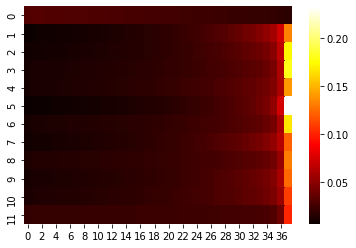

Train time: 2.859413512547811 min


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Distance:  586.4604316546763
Val time: 1.9666589061419169 min
Epoch 2...
Train_loss:  3.026745756582957


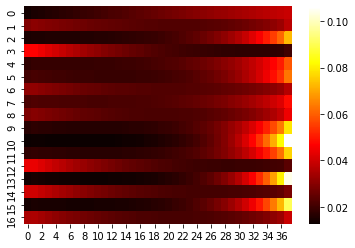

Train time: 2.880410929520925 min
Distance:  592.9244604316547
Val time: 1.9613311171531678 min
Epoch 3...
Train_loss:  3.0007739835066873


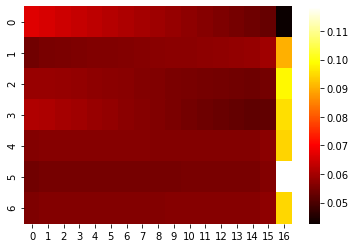

Train time: 2.8631344636281333 min
Distance:  131.76258992805757
Val time: 1.9544958273569744 min
Epoch 4...
Train_loss:  2.9854702285285653


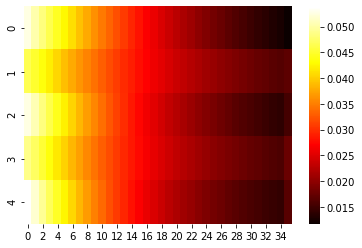

Train time: 2.8733399629592897 min
Distance:  503.99640287769785
Val time: 1.952439252535502 min
Epoch 5...
Train_loss:  2.9814891029700985


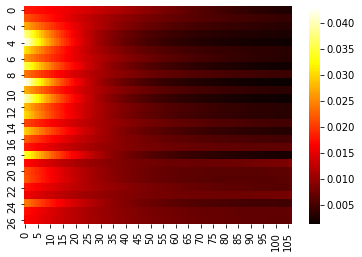

Train time: 2.8750692923863728 min
TARGET: ["- it's not like threads talk... - she's telling you to focus."]
PREDICTED: ['- tha                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ']
TARGET: ["let's make a promise that will never fade."]
PREDICTED: ['- tha                                it  on      on    on    on   on   on   on   on   on   on   on   on   on   on    on    on    on    on    on    on    on    on    on    on    o to to to to to to to to to to

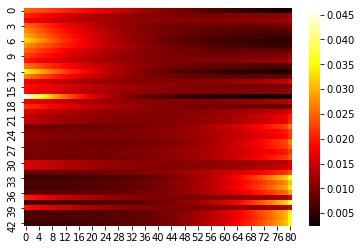

Train time: 2.885198442141215 min
Distance:  504.9136690647482
Val time: 1.9593188087145488 min
Epoch 7...
Train_loss:  2.9682467213310146


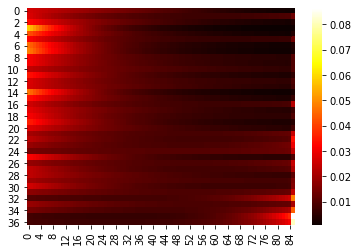

Train time: 2.918781566619873 min
Distance:  401.8021582733813
Val time: 2.013262073198954 min
Epoch 8...
Train_loss:  2.9625959316679533


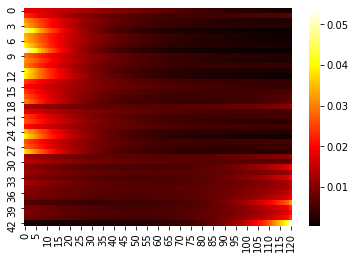

Train time: 2.912663479646047 min
Distance:  374.1798561151079
Val time: 2.002054246266683 min
Epoch 9...
Train_loss:  3.1158057043767626


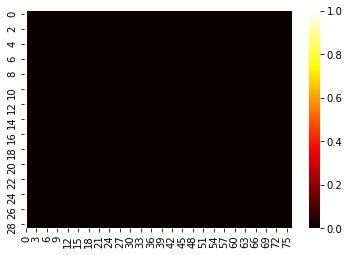

Train time: 2.8714816212654113 min
Distance:  586.2086330935252
Val time: 1.9440773248672485 min
Epoch 10...
Train_loss:  3.016867910636166


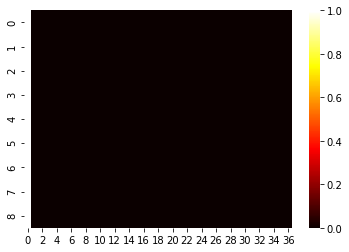

Train time: 2.8745919942855833 min
TARGET: ['thanks to my feminine powers!']
PREDICTED: ['- at i           o the   a t  o to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to ']
TARGET: ["it's still here."]
PREDICTED: ['- at i           o the   a t  o to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to 

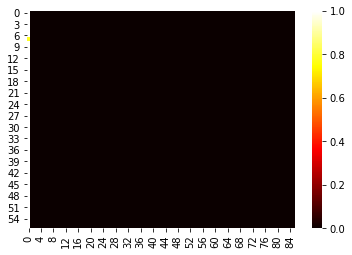

Train time: 2.909339654445648 min
Distance:  587.068345323741
Val time: 1.9771784623463948 min
Epoch 12...
Train_loss:  2.999569163155343


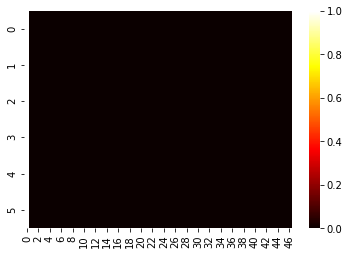

Train time: 2.86431192557017 min
Distance:  590.4928057553957
Val time: 1.9751707712809246 min
Epoch 13...
Train_loss:  2.9941787130759443


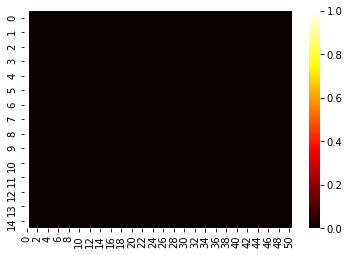

Train time: 2.916073437531789 min
Distance:  592.543165467626
Val time: 2.0138776103655496 min
Epoch 14...
Train_loss:  2.995108591064801


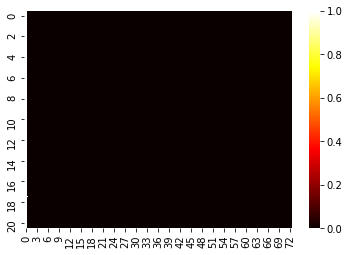

Train time: 2.9300071080525716 min
Distance:  587.9388489208633
Val time: 2.015497334798177 min
Epoch 15...
Train_loss:  2.9937562343222166


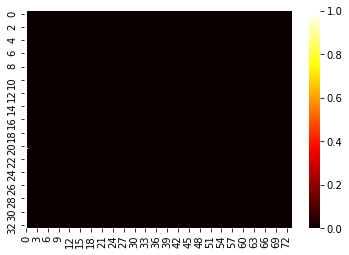

Train time: 2.878362997372945 min
TARGET: ['uh...']
PREDICTED: ['- ah  a  a                                                        a  ou  ou  ou  a  ou  a  ou  a  ou  a  ou  a  ou  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou ']
TARGET: ["i'm in tokyo!"]
PREDICTED: ['- ah  a  a                                                        a  ou  ou  ou  a  ou  a  ou  a  ou  a  ou  a  ou  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  a  ou  ou  a  ou  a  ou  a 

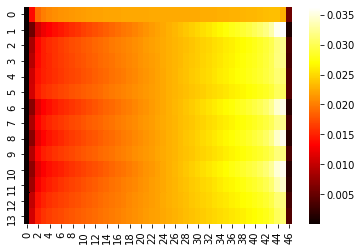

Train time: 2.912379030386607 min
Distance:  589.841726618705
Val time: 2.00392324924469 min
Epoch 17...


In [ ]:
n_epochs = 20
trialNumber = 4
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
mode = 'train'

for epoch in range(1, 21):#Try with another 10 epochs
  print(f"Epoch {epoch}...")
  start_time = time.time()
  
  att = train(model, train_loader, criterion, optimizer, mode)
  plot_attention(att)
  
  train_time = time.time()
  print(f"Train time: {(train_time - start_time)/60} min")

  val(model, valid_loader, epoch)
  
  val_time = time.time()
  print(f"Val time: {(val_time - train_time)/60} min")

  # Save model
  #filename = 'trial' + str(trialNumber) + 'epoch' + str(epoch) + '.pth'
  #path = '/content/drive/MyDrive/colab_notebooks/11785DL/project/model_result/' #content/drive/MyDrive/colab_notebooks/11785DL/HW1
  #torch.save(model.state_dict(), path + filename)